In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import arviz as az
import pymc as pm

# from matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('svg')

In [2]:
df = pd.read_csv("data/confirmed_daily_agg.csv")
df.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,Afghanistan,33.93911,67.709953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,453.0,505.0,406.0,242.0,547.0,628.0,840.0,623.0,764.0,981.0
1,Albania,41.15330,20.168300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,35.0,23.0,33.0,6.0,14.0,15.0,20.0,21.0,12.0
2,Algeria,28.03390,1.659600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,260.0,278.0,217.0,209.0,247.0,254.0,285.0,280.0,272.0,258.0
3,Andorra,42.50630,1.521800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,7.0,11.0,11.0,0.0
4,Angola,-11.20270,17.873900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,223.0,248.0,240.0,292.0,182.0,310.0,405.0,269.0,337.0,236.0


Саггрегируем по всем странам и посмотрим относительную величину `confirmed / confirmed_mean * 100`

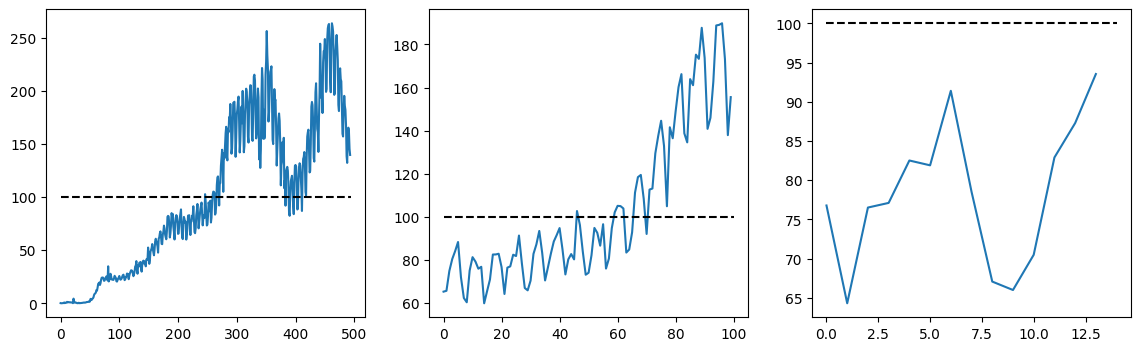

In [3]:
vals = df.iloc[:, 3:].values.sum(axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.plot(vals / vals.mean() * 100)
ax1.hlines(100, 0, len(vals), linestyle='--', color='black')

ax2.plot(vals[200:300] / vals.mean() * 100)
ax2.hlines(100, 0, 100, linestyle='--', color='black')

ax3.plot(vals[220:234] / vals.mean() * 100)
ax3.hlines(100, 0, 14, linestyle='--', color='black')

plt.show()

**Подготовим данные**:
- Нормализуем даты

In [4]:
data = {
    "Country": [],
    "Lat": [],
    "Long": [],
    "Confirmed": [],
    "Date": [],
}

dts = pd.to_datetime(df.columns[3:].tolist())
for idx in tqdm(df.index):
    for dt_raw, dt in zip(df.columns[3:].tolist(), dts):
        data["Country"].append(df.loc[idx, "Country/Region"])
        data["Lat"].append(df.loc[idx, "Lat"])
        data["Long"].append(df.loc[idx, "Long"])
        data["Confirmed"].append(df.loc[idx, dt_raw])
        data["Date"].append(dt)

data = pd.DataFrame(data)
print(data.shape)
data.head()

/tmp/ipykernel_234674/475045881.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dts = pd.to_datetime(df.columns[3:].tolist())


  0%|          | 0/193 [00:00<?, ?it/s]

(95342, 5)


,Country,Lat,Long,Confirmed,Date
0,Afghanistan,33.93911,67.709953,0.0,2020-01-22
1,Afghanistan,33.93911,67.709953,0.0,2020-01-23
2,Afghanistan,33.93911,67.709953,0.0,2020-01-24
3,Afghanistan,33.93911,67.709953,0.0,2020-01-25
4,Afghanistan,33.93911,67.709953,0.0,2020-01-26


**Нормализуем**

In [5]:
from sklearn.preprocessing import StandardScaler 

In [6]:
scaler = StandardScaler()

data["Date"] = (data["Date"] - data["Date"].min()) / pd.Timedelta(1, "D")
data[["Date"]] = scaler.fit_transform(data[["Date"]])
data.head()

,Country,Lat,Long,Confirmed,Date
0,Afghanistan,33.93911,67.709953,0.0,-1.728548
1,Afghanistan,33.93911,67.709953,0.0,-1.721536
2,Afghanistan,33.93911,67.709953,0.0,-1.714523
3,Afghanistan,33.93911,67.709953,0.0,-1.707511
4,Afghanistan,33.93911,67.709953,0.0,-1.700499


### Всеобщая агргеция

Для начала можно смотреть на показатели заболеваемости по всему миру в целом. В качестве модели предлагается попробовать **гауссовский процесс** из 2 компонент:
- **Тренда**
- Недельной **сезонности**

*TODO*

В дальнейшем можно попробовать обучить иерархические гауссовские процессы, без агрегации. То есть чтобы для каждой страны был свой процесс с параметрами из единого распределения

In [7]:
data = data[["Date", "Confirmed"]].groupby("Date", as_index=False).sum()
data["Confirmed"] = (data["Confirmed"] - data["Confirmed"].mean()) / data["Confirmed"].std()

data.head()

,Date,Confirmed
0,-1.728548,-1.367717
1,-1.721536,-1.369555
2,-1.714523,-1.368797
3,-1.707511,-1.367980
4,-1.700499,-1.367206


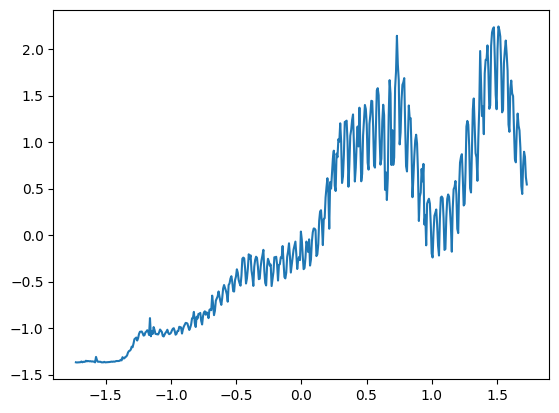

In [8]:
plt.plot(data["Date"].values, data["Confirmed"].values)
plt.show()

### Модель

In [32]:
coords = {
    "time": data["Date"].values,
    # "country": data["Country"].unique().values,
}


with pm.Model(coords=coords) as model:
    normalized_time_data = pm.Data(
        name="normalized_time_data", value=data["Date"].values, mutable=False, dims="time"
    )

    normalized_target_data = pm.Data(
        name="normalized_target_data",
        value=data["Confirmed"].values,
        mutable=False,
        dims="time",
    )

    # --- Priors ---

    # global trend
    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=3)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=normalized_time_data[:, None], dims="time")

    ## weekly periodic
    amplitude_week_periodic = pm.HalfNormal(name="amplitude_week_periodic", sigma=1)
    gp_week_periodic = pm.gp.HSGPPeriodic(
        m=20,
        scale=amplitude_week_periodic,
        cov_func=pm.gp.cov.Periodic(input_dim=1, period=7/scaler.scale_.item(), ls=1),
    )
    f_week_periodic = gp_week_periodic.prior(
        name="f_week_periodic", X=normalized_time_data[:, None], dims="time"
    )

    # global noise
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=f_trend + f_week_periodic,
        dims="time",
    )

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=normalized_target_data,
        dims="time",
    )

/home/leonardo/miniconda3/lib/python3.12/site-packages/pymc/data.py:423: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


### Prior check

In [33]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=2_000, random_seed=1337)

Sampling: [amplitude_trend, amplitude_week_periodic, f_trend_hsgp_coeffs_, f_week_periodic_hsgp_coeffs_, likelihood, sigma]


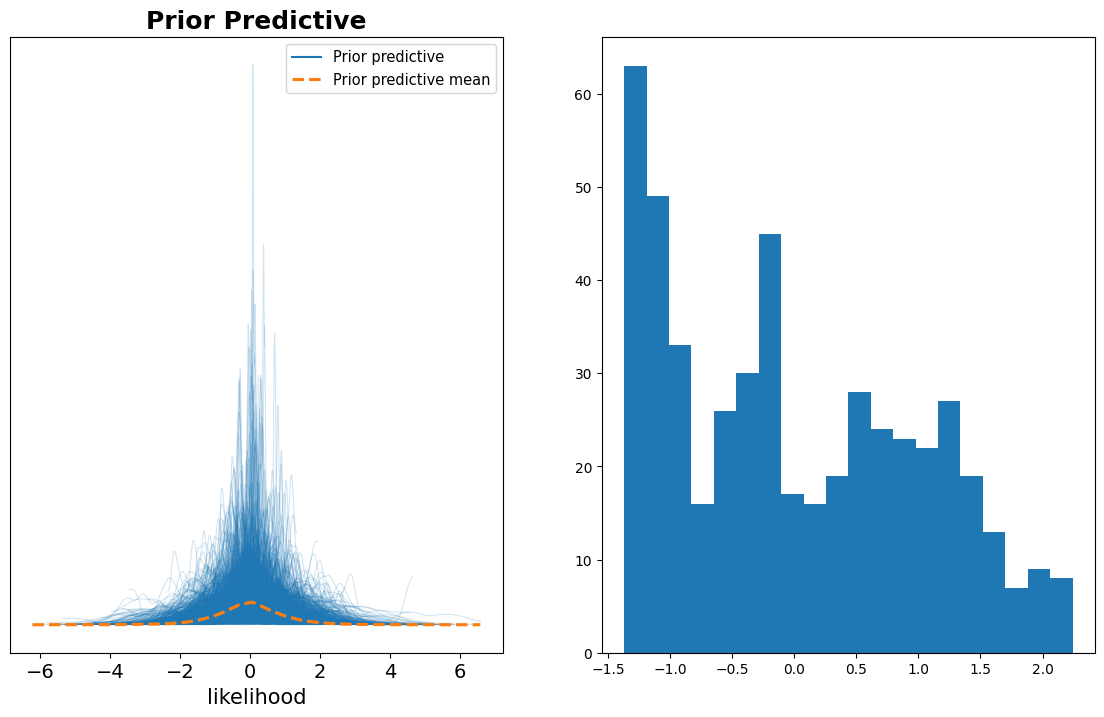

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax1)
ax1.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")
ax2.hist(data["Confirmed"].values, bins=20)

plt.show()

Априорное распределение более широкое, чем тергетное. Оно склонно генерировать значения примерно из того же диапазона, что нам и нужно

### Sampling

In [36]:
with model:
    idata = pm.sample(
        target_accept=0.9,
        draws=2_000,
        chains=4,
        random_seed=1337,
    )
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=1337))

Sampling: [likelihood]


Output()

### Posterior checks

In [37]:
var_names = [
    "amplitude_trend",
    "amplitude_week_periodic",
    "sigma",
]

az.summary(data=idata, var_names=var_names, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude_trend,5.447,0.569,4.383,6.527,0.008,0.006,4814.662,4755.911,1.002
amplitude_week_periodic,0.574,0.366,0.155,1.174,0.070,0.057,99.648,20.350,1.036
sigma,0.410,0.013,0.385,0.434,0.001,0.001,230.217,245.995,1.013


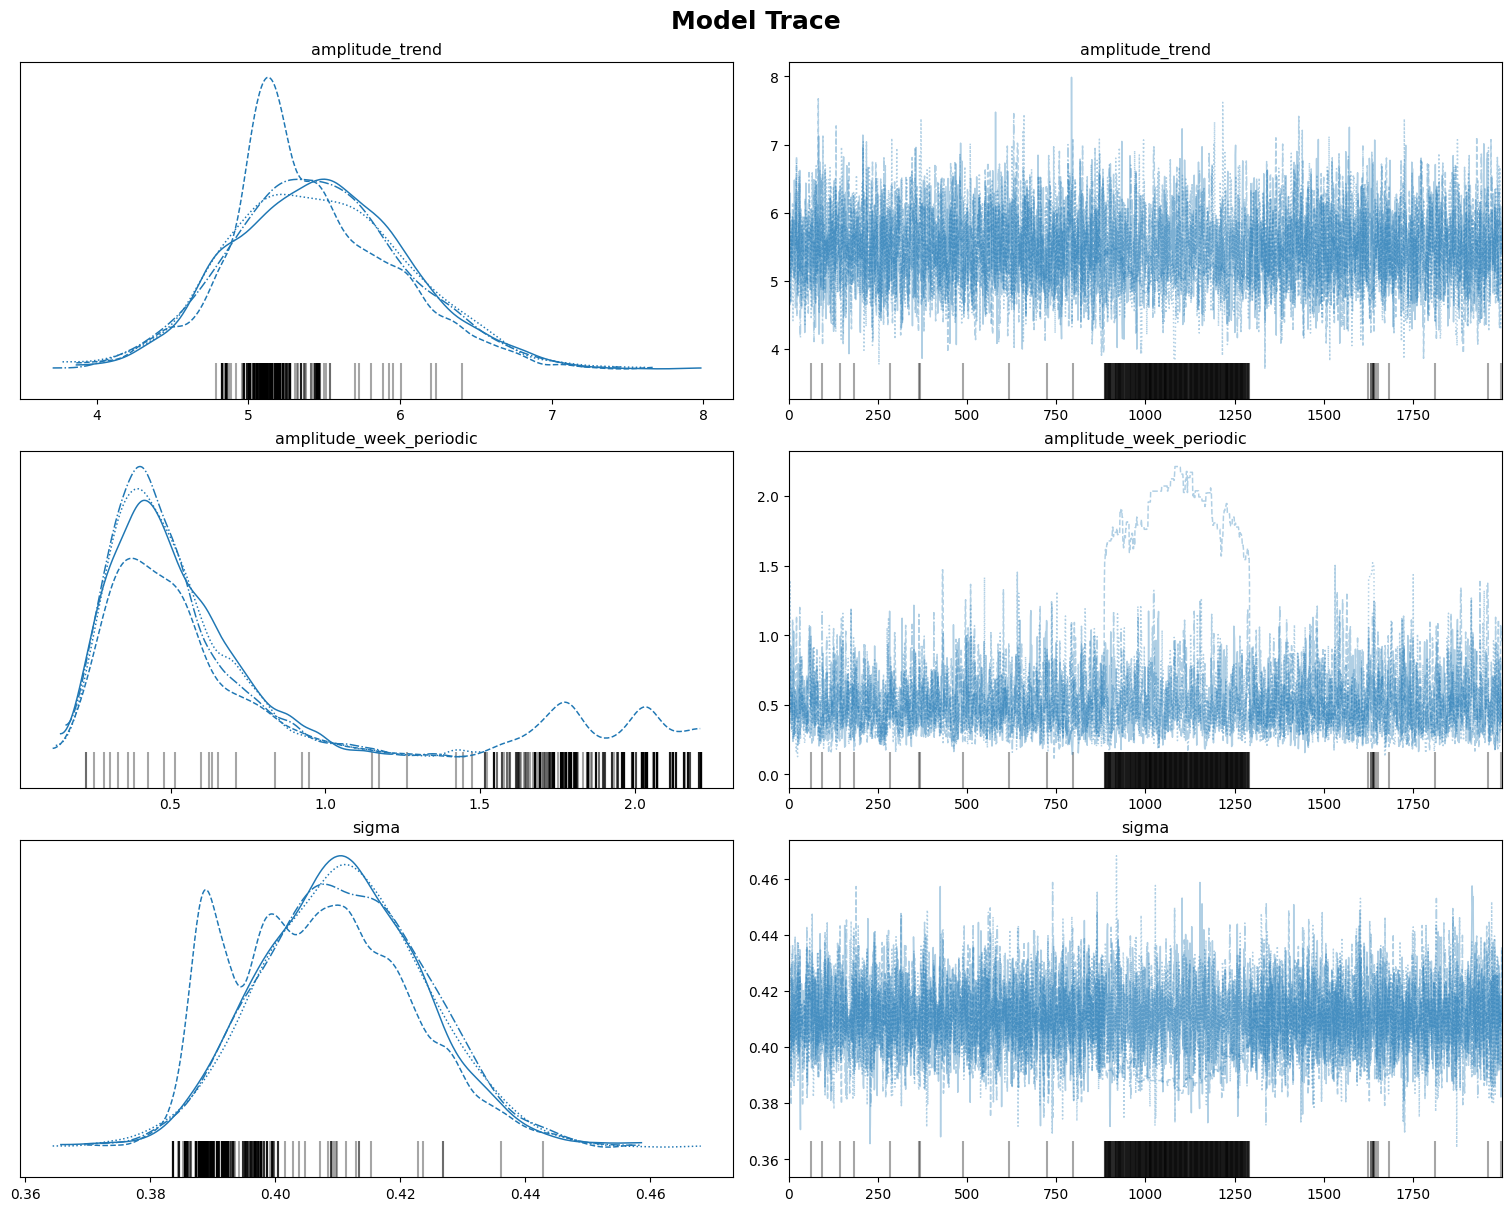

In [38]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (15, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold");

Для большинста цепочек моды апостериорных распределений параметров оказались близки, а случайные блуждания не задерживаются подолгу в одном месте. Это хорошо, говорит нам о том, что мы неплохо сошлись

Однако одна цепочка довольно сильно отличается от остальных, что, вероятно, говорит о недостаточной выразительности модели

Sampling: [likelihood]


Output()

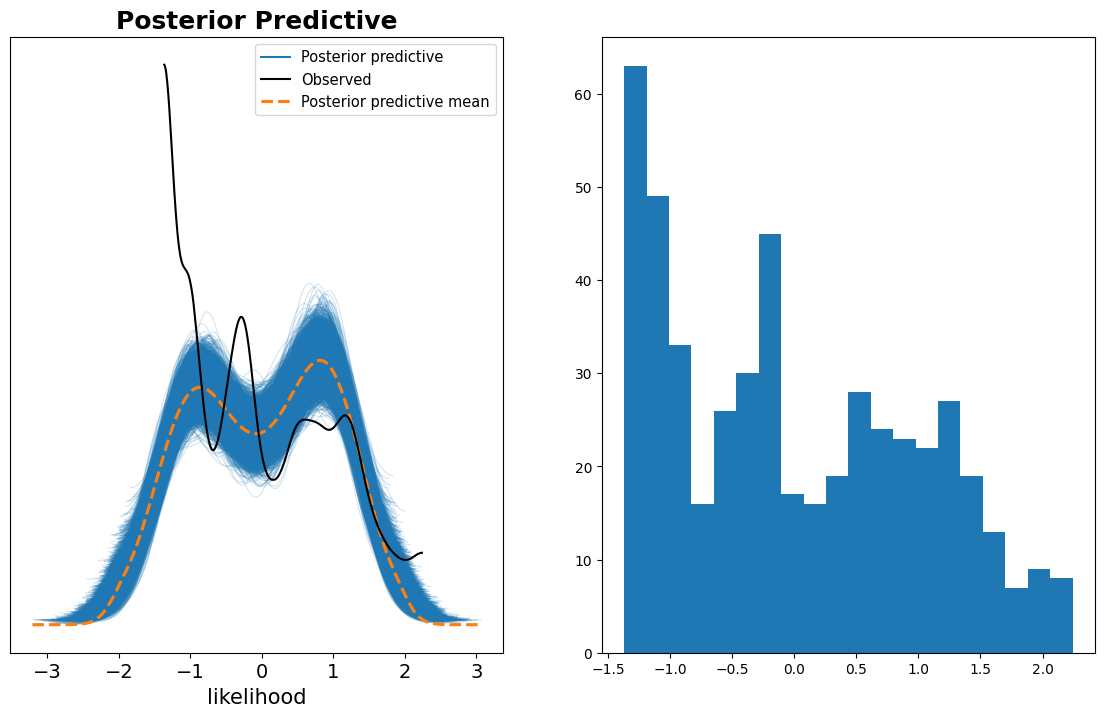

In [39]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
az.plot_ppc(data=posterior_predictive, group="posterior", kind="kde", ax=ax1)
ax1.set_title(label="Posterior Predictive", fontsize=18, fontweight="bold")
ax2.hist(data["Confirmed"].values, bins=20)
plt.show()

Если правую часть плотности распределения модель описывает ещё неплохо, то с левой беда. Модель не может обработать большое количество значений, которые до нормализации были околонулевыми

In [40]:
samples = posterior_predictive.posterior_predictive["likelihood"].values
samples = samples.reshape(-1, 494)

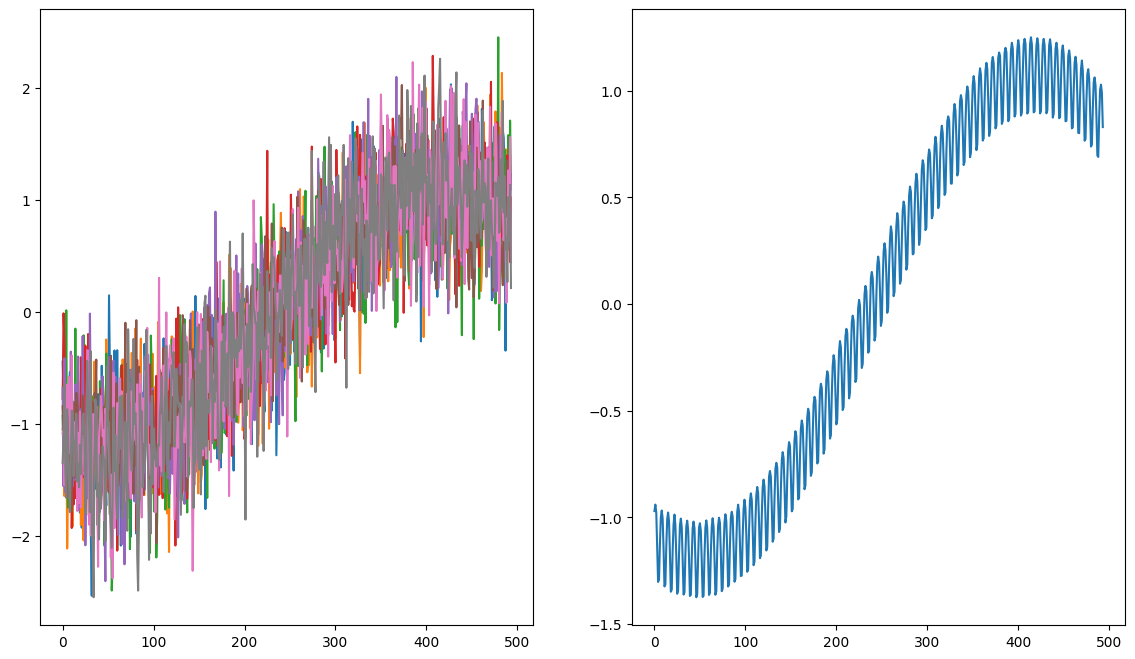

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

ax2.plot(samples.mean(axis=0))
for samp in samples[::1000]:
    ax1.plot(samp)

plt.show()

### Махинации над данными

Давайте теперь [в каком-то смысле как с лайками ВК] попробуем отбросить первые N дней, чтобы у распределения не было моды в нуле (то есть в точке куда ноль перейдёт после нормализации)

Возьмём `N = 100`

In [46]:
N = 100
df2 = df.drop(columns=df.columns[3: 3 + N])
print(df2.shape)
df2.head()

(193, 397)


,Country/Region,Lat,Long,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,Afghanistan,33.93911,67.709953,164.0,179.0,235.0,190.0,330.0,168.0,171.0,...,453.0,505.0,406.0,242.0,547.0,628.0,840.0,623.0,764.0,981.0
1,Albania,41.15330,20.168300,9.0,7.0,6.0,8.0,17.0,12.0,10.0,...,23.0,35.0,23.0,33.0,6.0,14.0,15.0,20.0,21.0,12.0
2,Algeria,28.03390,1.659600,148.0,141.0,179.0,174.0,190.0,159.0,185.0,...,260.0,278.0,217.0,209.0,247.0,254.0,285.0,280.0,272.0,258.0
3,Andorra,42.50630,1.521800,0.0,2.0,1.0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,4.0,7.0,11.0,11.0,0.0
4,Angola,-11.20270,17.873900,3.0,5.0,0.0,0.0,1.0,0.0,0.0,...,223.0,248.0,240.0,292.0,182.0,310.0,405.0,269.0,337.0,236.0


In [49]:
data2 = {
    "Country": [],
    "Lat": [],
    "Long": [],
    "Confirmed": [],
    "Date": [],
}

dts = pd.to_datetime(df2.columns[3:].tolist())
for idx in tqdm(df2.index):
    for dt_raw, dt2 in zip(df2.columns[3:].tolist(), dts):
        data2["Country"].append(df2.loc[idx, "Country/Region"])
        data2["Lat"].append(df2.loc[idx, "Lat"])
        data2["Long"].append(df2.loc[idx, "Long"])
        data2["Confirmed"].append(df2.loc[idx, dt_raw])
        data2["Date"].append(dt2)

data2 = pd.DataFrame(data2)
print(data2.shape)
data2.head()

/tmp/ipykernel_234674/2898849356.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dts = pd.to_datetime(df2.columns[3:].tolist())


  0%|          | 0/193 [00:00<?, ?it/s]

(76042, 5)


,Country,Lat,Long,Confirmed,Date
0,Afghanistan,33.93911,67.709953,164.0,2020-05-01
1,Afghanistan,33.93911,67.709953,179.0,2020-05-02
2,Afghanistan,33.93911,67.709953,235.0,2020-05-03
3,Afghanistan,33.93911,67.709953,190.0,2020-05-04
4,Afghanistan,33.93911,67.709953,330.0,2020-05-05


In [50]:
scaler2 = StandardScaler()

data2["Date"] = (data2["Date"] - data2["Date"].min()) / pd.Timedelta(1, "D")
data2[["Date"]] = scaler2.fit_transform(data2[["Date"]])

data2 = data2[["Date", "Confirmed"]].groupby("Date", as_index=False).sum()
data2["Confirmed"] = (data2["Confirmed"] - data2["Confirmed"].mean()) / data2["Confirmed"].std()

data2.head()

,Date,Confirmed
0,-1.727660,-1.527033
1,-1.718868,-1.566685
2,-1.710076,-1.581882
3,-1.701284,-1.575875
4,-1.692492,-1.563704


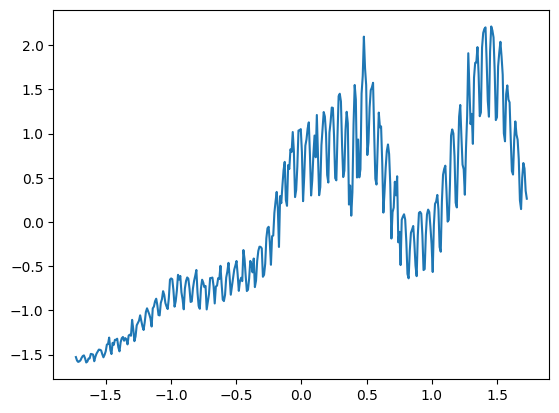

In [51]:
plt.plot(data2["Date"].values, data2["Confirmed"].values)
plt.show()

In [59]:
coords = {
    "time": data2["Date"].values,
}


with pm.Model(coords=coords) as model2:
    normalized_time_data = pm.Data(
        name="normalized_time_data", value=data2["Date"].values, mutable=False, dims="time"
    )

    normalized_target_data = pm.Data(
        name="normalized_target_data",
        value=data2["Confirmed"].values,
        mutable=False,
        dims="time",
    )

    # --- Priors ---

    # global trend
    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=3)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=normalized_time_data[:, None], dims="time")

    ## weekly periodic
    amplitude_week_periodic = pm.HalfNormal(name="amplitude_week_periodic", sigma=1)
    gp_week_periodic = pm.gp.HSGPPeriodic(
        m=20,
        scale=amplitude_week_periodic,
        cov_func=pm.gp.cov.Periodic(input_dim=1, period=7/scaler.scale_.item(), ls=1),
    )
    f_week_periodic = gp_week_periodic.prior(
        name="f_week_periodic", X=normalized_time_data[:, None], dims="time"
    )

    # global noise
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=f_trend + f_week_periodic,
        dims="time",
    )

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=normalized_target_data,
        dims="time",
    )

/home/leonardo/miniconda3/lib/python3.12/site-packages/pymc/data.py:423: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


**Priors**

Sampling: [amplitude_trend, amplitude_week_periodic, f_trend_hsgp_coeffs_, f_week_periodic_hsgp_coeffs_, likelihood, sigma]


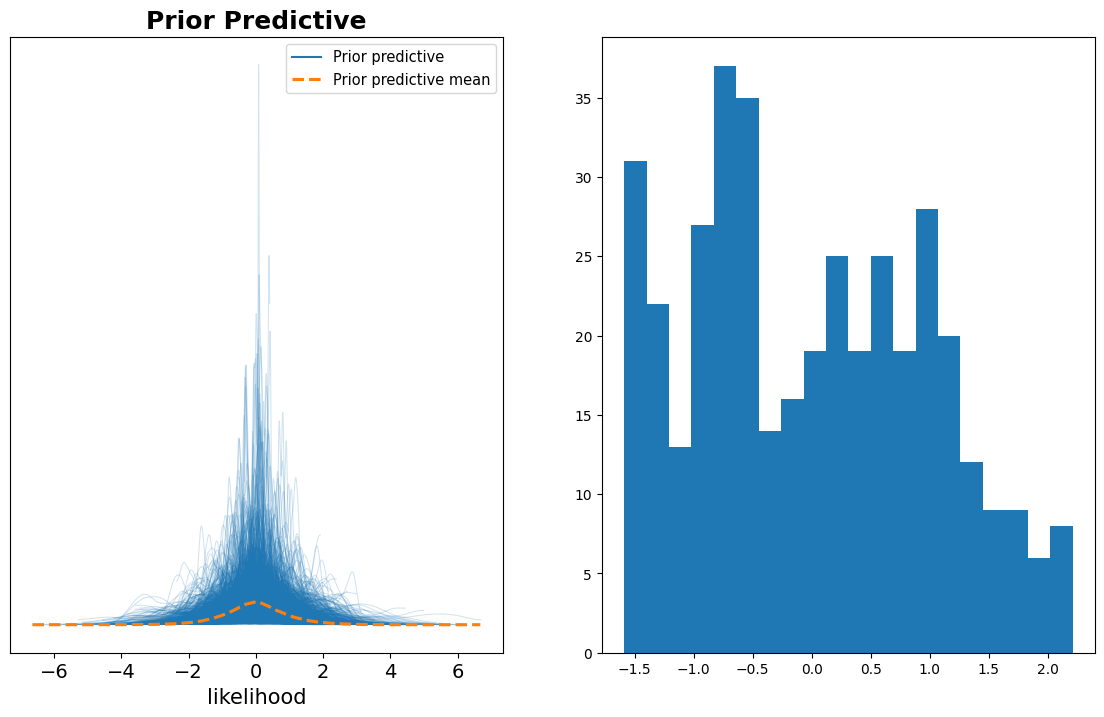

In [60]:
with model2:
    prior_predictive = pm.sample_prior_predictive(samples=2_000, random_seed=1337)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax1)
ax1.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")
ax2.hist(data2["Confirmed"].values, bins=20)

plt.show()

In [61]:
with model2:
    idata2 = pm.sample(
        target_accept=0.9,
        draws=2_000,
        chains=4,
        random_seed=1337,
    )
    idata2.extend(pm.sample_posterior_predictive(trace=idata2, random_seed=1337))

var_names = [
    "amplitude_trend",
    "amplitude_week_periodic",
    "sigma",
]

az.summary(data=idata2, var_names=var_names, round_to=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [amplitude_trend, f_trend_hsgp_coeffs_, amplitude_week_periodic, f_week_periodic_hsgp_coeffs_, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 246 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude_trend,4.949,0.580,3.858,6.016,0.005,0.004,11292.632,6687.870,1.000
amplitude_week_periodic,0.882,0.303,0.370,1.465,0.005,0.003,3960.681,5204.715,1.001
sigma,0.573,0.021,0.534,0.611,0.000,0.000,17700.687,5300.385,1.001


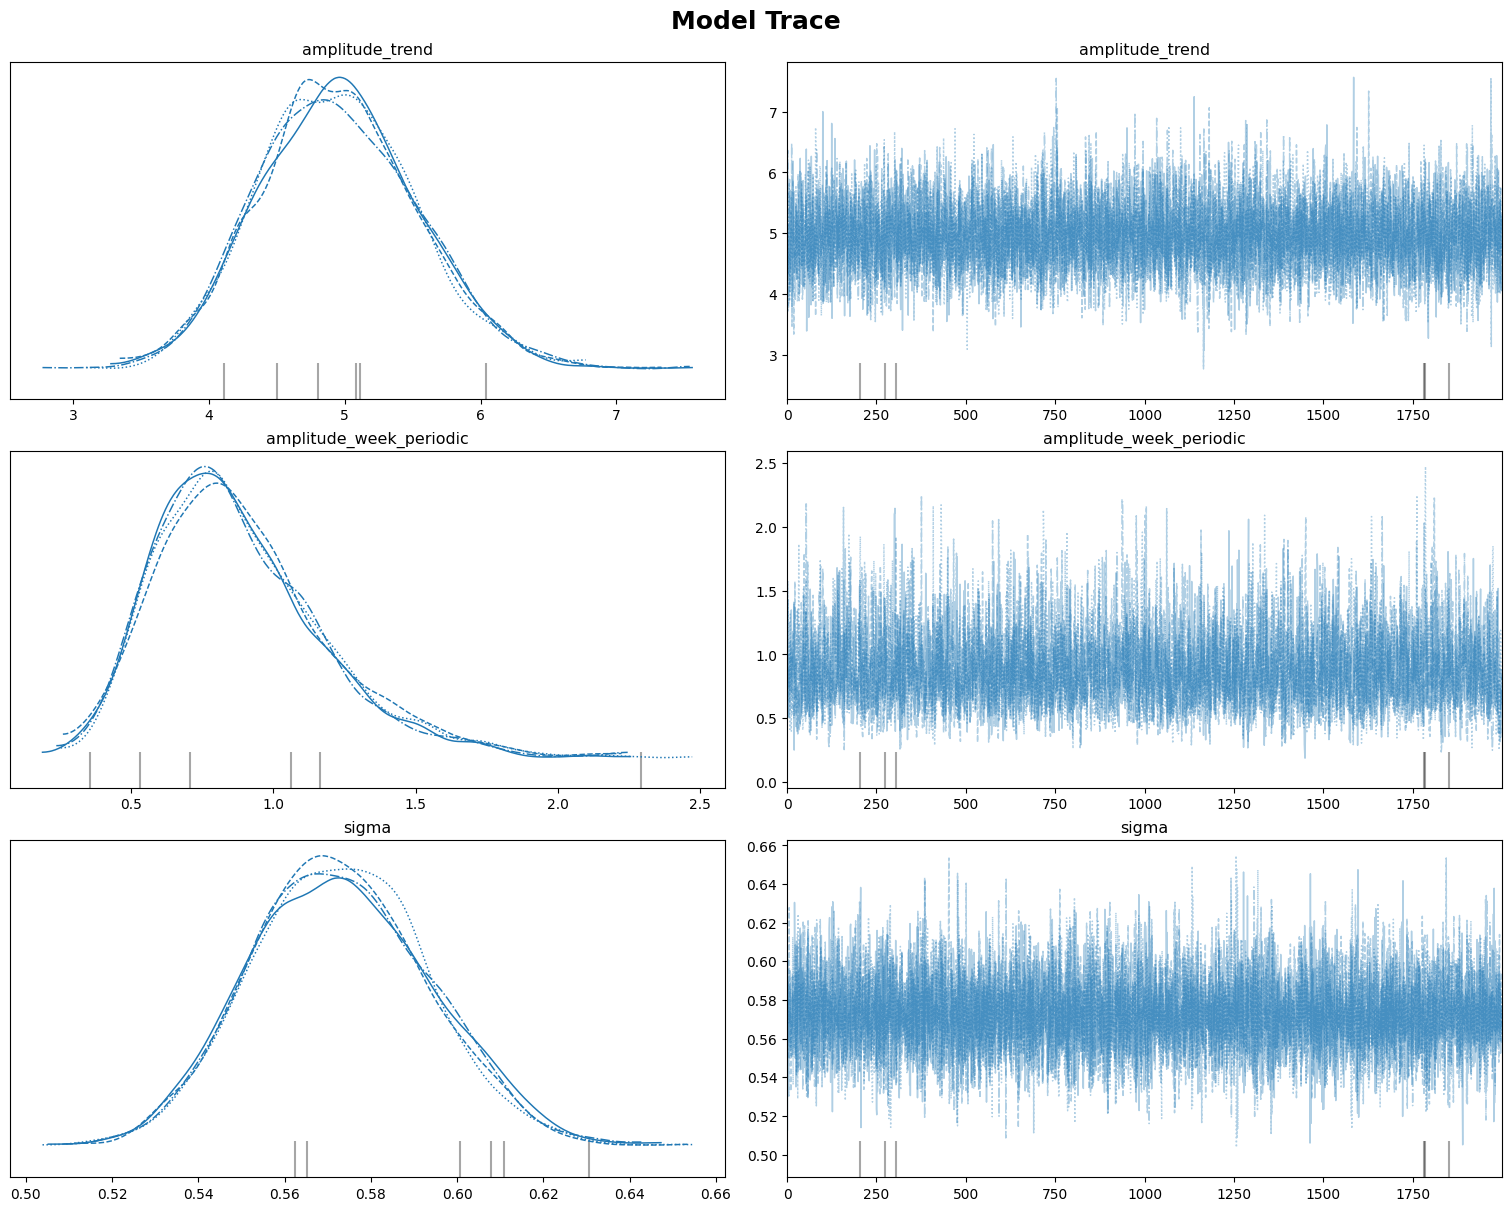

In [62]:
axes = az.plot_trace(
    data=idata2,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (15, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold");

На этот раз все цепочки более-менее сошлись!

Sampling: [likelihood]


Output()

/home/leonardo/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


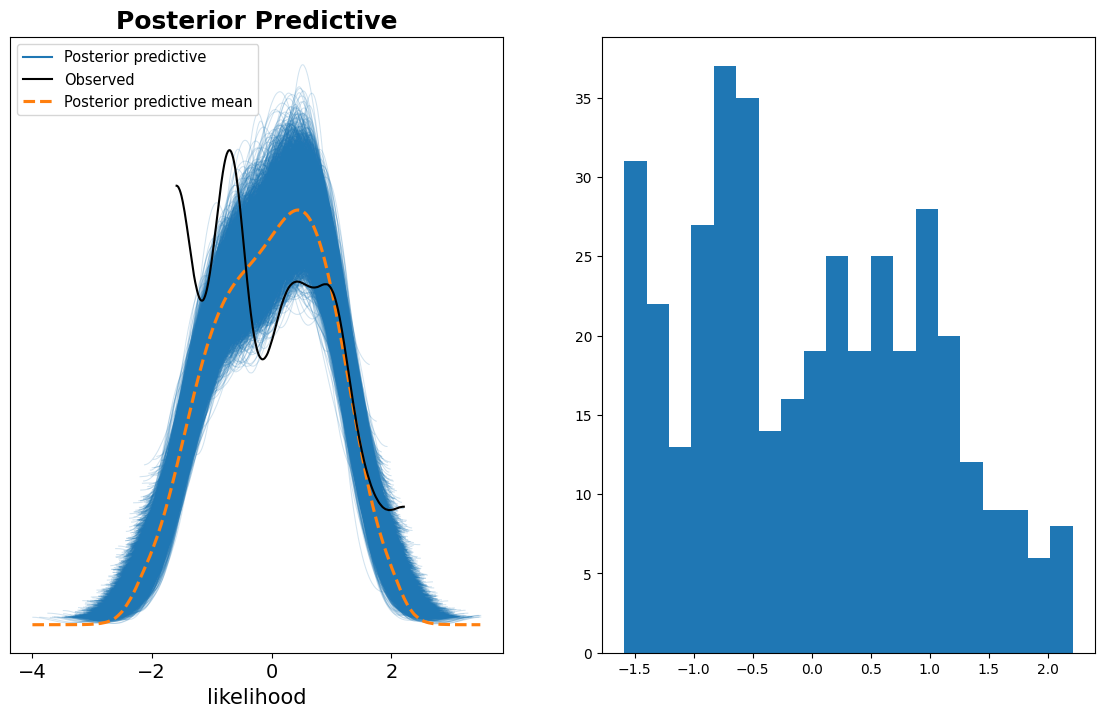

In [63]:
with model2:
    posterior_predictive2 = pm.sample_posterior_predictive(idata2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
az.plot_ppc(data=posterior_predictive2, group="posterior", kind="kde", ax=ax1)
ax1.set_title(label="Posterior Predictive", fontsize=18, fontweight="bold")
ax2.hist(data2["Confirmed"].values, bins=20)
plt.show()

Всё равно плохо описываем левый конец распределения, но уже лучше